In [3]:
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from tqdm.auto import tqdm

import PIL
from PIL import Image
import rasterio

import requests

import scipy.stats as stats

# Gen Points

In [2]:
tif_file = rasterio.open('population/population_heatmap.tif')
heatmap = tif_file.read() + 200
heatmap /= heatmap.max()
heatmap = heatmap.squeeze(0)

In [25]:
from multiprocessing import Process
from gen_points import gen_points
for i in range(6):
    t = Process(target=gen_points, args=(heatmap, i))
    t.start()

Predicting
Predicting(1.06%)
Predicting(1.17%)
Predicting(2.22%)
Predicting(1.02%)
Predicting(2.27%))


In [248]:
points = np.load('points.npy')
for i in range(0, 6):
    points = np.concatenate((points, np.load(f'points_{i}.npy')))

In [65]:
np.save('points.npy', points)

In [ ]:
for i, point in enumerate(coords_df.geometry):
    if not world.contains(point).any():
        coords_df.drop(i, inplace=True)

In [2]:
coords_df = coords_df.reindex()
coords_df.to_pickle('coords_df.pkl')

NameError: name 'coords_df' is not defined

# Mask Points

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
coords_df = pd.read_pickle('coords_df.pkl')

In [3]:
china = world[world['name'] == 'China'].geometry
africa = world[world['continent'] == 'Africa'].geometry
india = world[world['name'] == 'India'].geometry

for i, point in enumerate(coords_df.geometry):
    if china.contains(point).all():
        coords_df.iloc[i] = None
coords_df.dropna(inplace=True)
coords_df = coords_df.reset_index()
print("China Gone")

for i, point in enumerate(coords_df.geometry):
    for geom in africa:
        if geom.contains(point):
            if np.random.uniform() > 0.75:
                coords_df.iloc[i] = None
coords_df.dropna(inplace=True)
coords_df = coords_df.reset_index()
print("Africa Gone")

for i, point in enumerate(coords_df.geometry):
    for geom in india:
        if geom.contains(point):
            if np.random.uniform() > 0.25:
                coords_df.iloc[i] = None
coords_df.dropna(inplace=True)
coords_df = coords_df.reset_index()
print("India Gone")

coords_df.to_pickle('coords_df_masked.pkl')

In [210]:
coords_df = gpd.GeoDataFrame(geometry=[Point(-137.899731, 66.488417)])
# world = world.to_crs('EPSG:3857')
world = world[world['continent'] != 'Antarctica']

<AxesSubplot: >

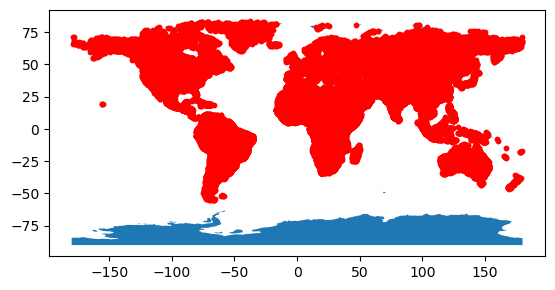

In [3]:
world_plot = world.plot()

coords_df.plot(ax=world_plot, marker='o', color='red', markersize=0.05)

<AxesSubplot: >

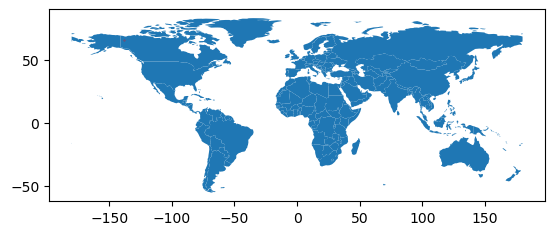

In [213]:
world_plot = world.plot()
coords_df.plot(ax=world_plot, marker='o', color='red', markersize=0.05)

# Get Nearest Road

In [5]:
coords_df_masked = pd.read_pickle('coords_df_masked.pkl')
coords = coords_df_masked.geometry

In [4]:
coords.head()

0    POINT (-71.23103 83.11540)
1    POINT (-36.58970 82.32077)
2    POINT (-27.64766 81.63364)
3    POINT (-78.17895 81.39289)
4    POINT (-38.89597 81.28131)
Name: geometry, dtype: geometry

In [ ]:
for i, point in enumerate(coords_df_masked.geometry):
    if np.random.uniform() > 0.65:
        coords_df_masked.iloc[i] = None
coords_df_masked.dropna(inplace=True)
coords_df_masked = coords_df_masked.reset_index()

In [6]:
key = input("Enter API Key: ")

In [14]:
def get_data():
    url = 'https://maps.googleapis.com/maps/api/streetview/metadata'
    

    file_names = os.listdir('data/')
    save_file_names = []
    countries = []
    img_coords = []
    i = 0
    while i < maxv - minv:
        con = True
        if not file_names[i][-5].isnumeric() or int(file_names[i][-5]) != 0:
            i += 1
            con = False
        
        if con:
            file_name = file_names[i][:-6]
            idx = int(file_name[-6:])
            
            lat, lon = coords[idx].y, coords[idx].x

            params = {
                'key': key,
                'size': '640x640',
                'location': f'{lat:.3f},{lon:.3f}',
                'heading': 90,
                'pitch': '20',
                'fov': '90',
                'radius': 1000000
                }

            response = requests.get(url, params)
            if response.json()['status'] == "OK":
                lat, lon = response.json()['location']['lat'], response.json()['location']['lng']
            else:
                lat, lon = 0, 0
            
            for j, country in enumerate(world.geometry):
                if country.contains(Point(lon, lat)):
                    save_file_names.append(file_name)
                    countries.append(j)
                    img_coords.append([lat, lon])
            
            i += 3
        
        print(f"Image {i} Percent: {(i) / (maxv) * 100:.2f}%", end='\r')
        
    pd.DataFrame({'file_name': save_file_names, 'country': countries, 'coords': img_coords}).to_pickle(f'df_{minv}_{maxv}.df')
    # Save the coordinates to the output file


In [7]:
data_len = len(os.listdir('data/'))
data_len = data_len // 6
data_len

15696

In [8]:
from multiprocessing import Process
from get_loc import get_data
for i in range(6):
    t = Process(target=get_data, args=(i*data_len, (i+1)*data_len, coords, key, world))
    t.start()

/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


In [12]:
pkl = pd.read_pickle('df_78480_94176.df')
pkl.head()

,file_name,country,coords
0,street_view_014085,44,"[-2.6174365, -78.4535424]"
1,street_view_013942,138,"[6.9134071, 80.3828554]"
2,street_view_009098,4,"[37.87522209999999, -81.0356791]"
3,street_view_004107,137,"[-25.3012726, 130.6902566]"
4,street_view_003417,55,"[18.6873527, 6.203693299999999]"


In [11]:
from get_loc import get_data
get_data(1*data_len, (1+1)*data_len, coords, key, world)

IndexError: list index out of range

In [35]:
response.json()

{'copyright': '© PT. Sumber Daya Wahana',
 'date': '2022-02',
 'location': {'lat': -2.8522972, 'lng': 129.7221903},
 'pano_id': 'CAoSLEFGMVFpcFBZOUJrNjdjeVBYNlJ1eGhDcGVtbGR1X3IwY2N6Qld6M090R25x',
 'status': 'OK'}

In [14]:
datasets = []
for i in range(6):
    dataset = pd.read_pickle(f'df_{i*data_len}_{(i+1)*data_len}.df')
    datasets.append(dataset)

dataset = pd.concat(datasets)
dataset.to_pickle('data/dataset.df')

In [12]:
len(dataset)

19161

In [10]:
for dataset in datasets:
    print(len(dataset))

2708
2709
2688
2709
2719
2721
